# OCR Service Quality Testing

This notebook tests the quality and performance of the OCR service for receipt text extraction.

## Features:
- Test individual images or batch processing
- Measure OCR accuracy and confidence scores
- Visualize preprocessing steps
- Compare different languages (English vs Portuguese)
- Performance benchmarking

## 1. Setup and Imports

In [3]:
import sys
from pathlib import Path
import time
from typing import List, Dict, Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Add project root to path
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import OCR service
from agent_api.services.ocr import OCRService

print("✅ All imports successful!")

✅ All imports successful!


## 2. Helper Functions

In [4]:
def load_image_bytes(image_path: str) -> bytes:
    """Load image file as bytes."""
    with open(image_path, 'rb') as f:
        return f.read()

def display_images(original_bytes: bytes, preprocessed: np.ndarray, title: str = "Image Comparison"):
    """Display original and preprocessed images side by side."""
    # Convert bytes to image for display
    nparr = np.frombuffer(original_bytes, np.uint8)
    original = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    axes[0].imshow(original_rgb)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(preprocessed, cmap='gray')
    axes[1].set_title('Preprocessed Image (Grayscale + Otsu Threshold)')
    axes[1].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def calculate_accuracy(extracted_text: str, ground_truth: str) -> float:
    """Calculate character-level accuracy between extracted and ground truth text."""
    if not ground_truth:
        return 0.0
    
    # Simple character matching (case-insensitive)
    extracted_clean = extracted_text.lower().replace(' ', '').replace('\n', '')
    truth_clean = ground_truth.lower().replace(' ', '').replace('\n', '')
    
    # Calculate Levenshtein distance for better accuracy
    from difflib import SequenceMatcher
    matcher = SequenceMatcher(None, extracted_clean, truth_clean)
    return matcher.ratio() * 100

async def test_single_image(
    image_path: str, 
    ground_truth: str = None, 
    lang: str = "eng",
    show_images: bool = True
) -> Dict:
    """Test OCR on a single image and return metrics."""
    print(f"\n{'='*60}")
    print(f"Testing: {Path(image_path).name}")
    print(f"{'='*60}")
    
    # Load image
    image_bytes = load_image_bytes(image_path)
    
    # Preprocess and visualize
    start_preprocess = time.time()
    preprocessed = await OCRService.preprocess_image(image_bytes)
    preprocess_time = time.time() - start_preprocess
    
    if show_images:
        display_images(image_bytes, preprocessed, f"Processing: {Path(image_path).name}")
    
    # Extract text
    start_ocr = time.time()
    extracted_text, confidence = await OCRService.extract_text(image_bytes, lang=lang)
    ocr_time = time.time() - start_ocr
    
    # Calculate metrics
    accuracy = calculate_accuracy(extracted_text, ground_truth) if ground_truth else None
    
    # Display results
    print(f"\n📊 Results:")
    print(f"  • Confidence Score: {confidence:.2f}%")
    if accuracy is not None:
        print(f"  • Accuracy: {accuracy:.2f}%")
    print(f"  • Preprocessing Time: {preprocess_time*1000:.2f}ms")
    print(f"  • OCR Time: {ocr_time*1000:.2f}ms")
    print(f"  • Total Time: {(preprocess_time + ocr_time)*1000:.2f}ms")
    print(f"  • Characters Extracted: {len(extracted_text)}")
    
    print(f"\n📝 Extracted Text:")
    print("-" * 60)
    print(extracted_text)
    print("-" * 60)
    
    if ground_truth:
        print(f"\n✓ Ground Truth:")
        print("-" * 60)
        print(ground_truth)
        print("-" * 60)
    
    return {
        'image': Path(image_path).name,
        'confidence': confidence,
        'accuracy': accuracy,
        'preprocess_time_ms': preprocess_time * 1000,
        'ocr_time_ms': ocr_time * 1000,
        'total_time_ms': (preprocess_time + ocr_time) * 1000,
        'char_count': len(extracted_text),
        'extracted_text': extracted_text
    }

print("✅ Helper functions loaded!")

✅ Helper functions loaded!


## 3. Single Image Test

Test a single image with optional ground truth for accuracy measurement.


Testing: nota_008.jpg


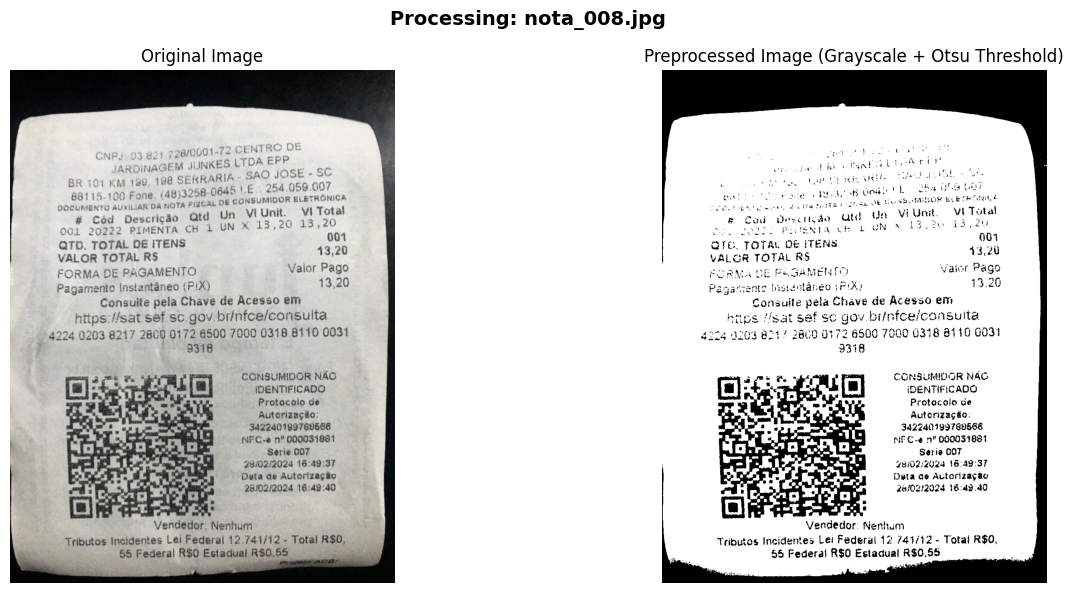

2026-02-11 20:51:38,355 - agent_api.services.ocr - INFO - Starting OCR text extraction with language: por
2026-02-11 20:51:40,123 - agent_api.services.ocr - INFO - OCR completed. Extracted 719 characters with 40.04% confidence

📊 Results:
  • Confidence Score: 40.04%
  • Accuracy: 1.38%
  • Preprocessing Time: 43.40ms
  • OCR Time: 1768.47ms
  • Total Time: 1811.87ms
  • Characters Extracted: 719

📝 Extracted Text:
------------------------------------------------------------
pet e linto toda Ari

” . ri

: peoeito DO Sado ro
o “ Ca! ma Dia LUOT
va ' 1 toa il cia Dra Qdse
NU ' era OE COND ORDER ELECRONCL
COS TOEN O matr ati

g Cod de crição que tin Vi Unit. VI Total
ja ch ivo 13,20 d5,du

* SOIE n

GTE. TOTAL DE ITENS SO
VALOR TOTAL R$ 13,20
FORMA DE PAGAMENTO valor Pago

to Instantâneo (PR) 13,20
consuite pela Chave de Acesso em
= sat sef sc gov brinice/consuita
alta 9204 8747 2800 DT72 6500 7000 0358 8110 0031
3318

CONSUMIDOR NÃO
IDENTIFICADO
Protovolo ue
Autorização:

34224019976058

In [5]:
# Configuration
TEST_IMAGE_PATH = "/Users/joaoflauzino/Downloads/nota_008.jpg"  # ⚠️ UPDATE THIS PATH
GROUND_TRUTH = "13.20"# Optional: Add expected text
LANGUAGE = "por"  # Use "por" for Portuguese

# Run test
result = await test_single_image(
    image_path=TEST_IMAGE_PATH,
    ground_truth=GROUND_TRUTH if GROUND_TRUTH.strip() else None,
    lang=LANGUAGE,
    show_images=True
)

print(result)

## 4. Batch Testing

Test multiple images and generate a summary report.

In [7]:
# Define test cases
# Format: (image_path, ground_truth, language)
TEST_CASES = [
    ("/Users/joaoflauzino/Downloads/nota_001.jpg", "9,28", "por"),
    ("/Users/joaoflauzino/Downloads/nota_002.jpg", "289,90", "por"),
    ("/Users/joaoflauzino/Downloads/nota_007.jpg", "5,98", "por"),
    ("/Users/joaoflauzino/Downloads/nota_008.jpg", "13,20", "por"),
]

async def run_batch_tests(test_cases: List[Tuple[str, str, str]], show_images: bool = False):
    """Run OCR tests on multiple images."""
    results = []
    
    for image_path, ground_truth, lang in test_cases:
        try:
            result = await test_single_image(
                image_path=image_path,
                ground_truth=ground_truth if ground_truth.strip() else None,
                lang=lang,
                show_images=show_images
            )
            results.append(result)
        except Exception as e:
            print(f"❌ Error processing {image_path}: {e}")
            results.append({
                'image': Path(image_path).name,
                'error': str(e)
            })
    
    return results

# Run batch tests (set show_images=True to see all preprocessing steps)
batch_results = await run_batch_tests(TEST_CASES, show_images=False)

print("✅ Batch testing function ready! Uncomment the line above to run.")


Testing: nota_001.jpg
2026-02-11 20:53:41,861 - agent_api.services.ocr - INFO - Starting OCR text extraction with language: por
2026-02-11 20:53:42,960 - agent_api.services.ocr - INFO - OCR completed. Extracted 686 characters with 42.37% confidence

📊 Results:
  • Confidence Score: 42.37%
  • Accuracy: 1.37%
  • Preprocessing Time: 17.08ms
  • OCR Time: 1100.98ms
  • Total Time: 1118.06ms
  • Characters Extracted: 686

📝 Extracted Text:
------------------------------------------------------------
MONTEIRO BRAGA CONSULTORIA BMPRESARIAL LTDA
DEALERNET

R. ANDRÉ. R. DA FONTE, 25/26 - SALA 601

42.700-000 L. DE FREITAS - BA

CNPJ :63.358.000/0001 -49

1E:66994360-NO UF:BA

CHPJ/CPF consumidor:21).113.221/11

HOME :URSO DA BATUCADA

EMD:RUA ALMIRANTE BARROSO, NºS0, VITORIA, CEP:4
0275240, SALVADOR-BA

CUPOM FISCAL

ITEM CÓDIGO DESCRIÇÃO QTD.UN.YL UNIT( R$) ST VL.
ITEM( R$)

001 13335708 ABRACADEIRA 90.5
JUR X 9,28 EE 9,289

TOTAL R$ 9,28

DINREIRO 9,28

HD-S:cbf73ccO9fffc7eeSfabacbád9f3901

## 5. Results Analysis


📊 Summary Statistics:
Total Images Tested: 4
Average Confidence: 35.77%
Average Accuracy: 1.69%
Average Processing Time: 1236.12ms
Average Characters Extracted: 683

📋 Detailed Results:


,image,confidence,accuracy,total_time_ms,char_count
0,nota_001.jpg,42.370370,1.365188,1118.057966,686
1,nota_002.jpg,24.401515,2.512563,797.443867,467
2,nota_007.jpg,36.264901,1.149425,1307.783365,861
3,nota_008.jpg,40.044828,1.730104,1721.207857,719


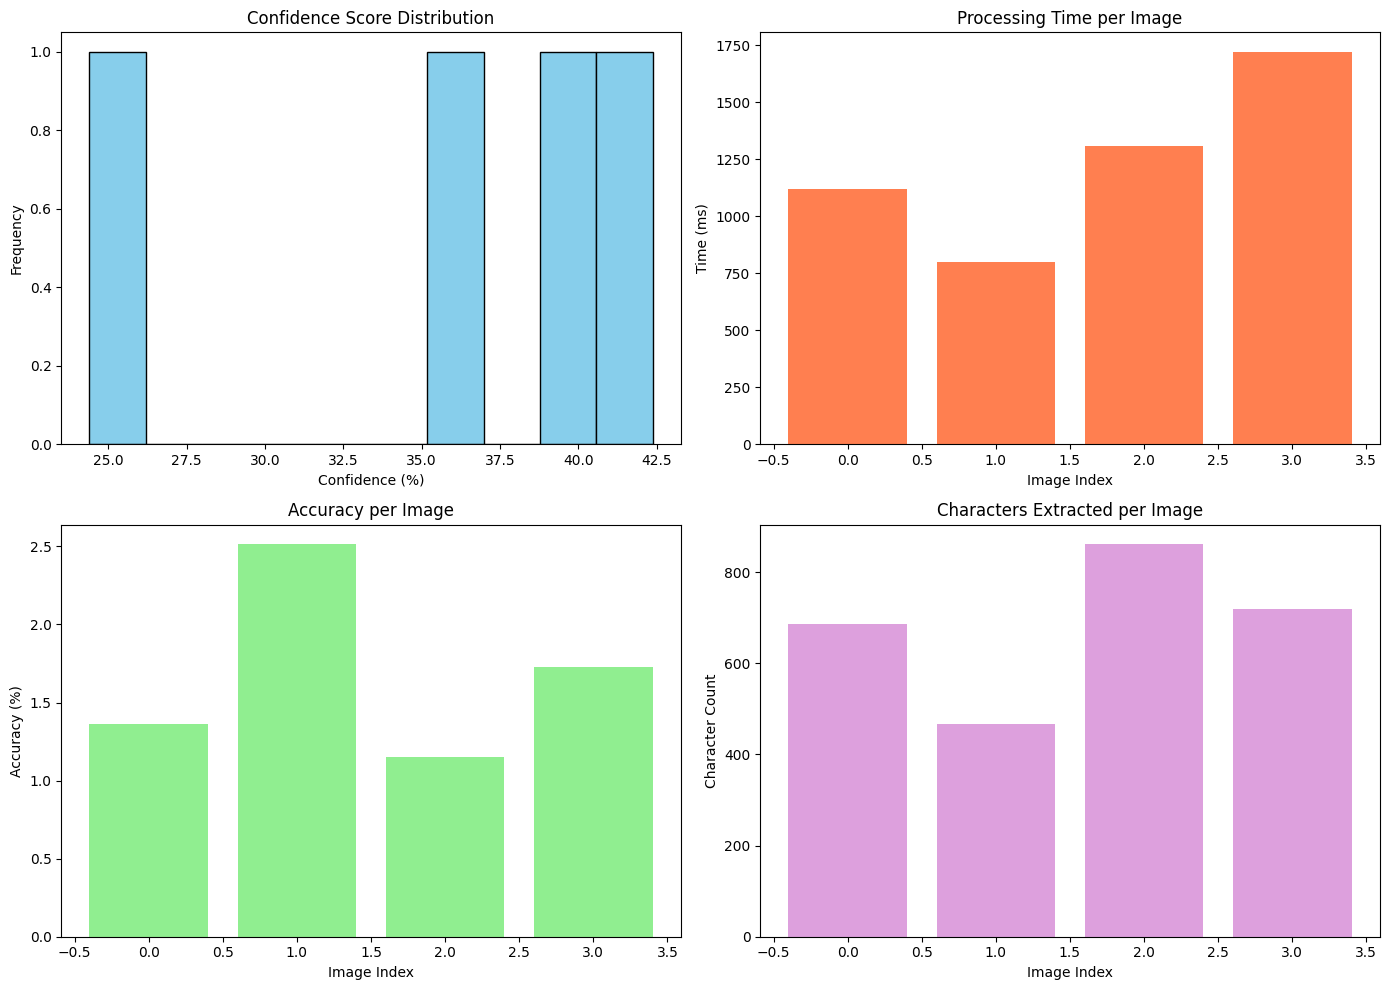

✅ Analysis functions ready! Uncomment the code above after running batch tests.


In [16]:
# Analyze batch results (uncomment after running batch tests)
df = pd.DataFrame(batch_results)
if "error" in df.columns:
    df = df[df['error'].isna()]  # Filter out errors

print("\n📊 Summary Statistics:")
print("=" * 60)
print(f"Total Images Tested: {len(df)}")
print(f"Average Confidence: {df['confidence'].mean():.2f}%")
if 'accuracy' in df.columns and df['accuracy'].notna().any():
    print(f"Average Accuracy: {df['accuracy'].mean():.2f}%")
print(f"Average Processing Time: {df['total_time_ms'].mean():.2f}ms")
print(f"Average Characters Extracted: {df['char_count'].mean():.0f}")

# Display detailed results table
print("\n📋 Detailed Results:")
display(df[['image', 'confidence', 'accuracy', 'total_time_ms', 'char_count']])

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Confidence distribution
axes[0, 0].hist(df['confidence'], bins=10, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Confidence Score Distribution')
axes[0, 0].set_xlabel('Confidence (%)')
axes[0, 0].set_ylabel('Frequency')

# Processing time
axes[0, 1].bar(range(len(df)), df['total_time_ms'], color='coral')
axes[0, 1].set_title('Processing Time per Image')
axes[0, 1].set_xlabel('Image Index')
axes[0, 1].set_ylabel('Time (ms)')

# Accuracy (if available)
if 'accuracy' in df.columns and df['accuracy'].notna().any():
    axes[1, 0].bar(range(len(df)), df['accuracy'], color='lightgreen')
    axes[1, 0].set_title('Accuracy per Image')
    axes[1, 0].set_xlabel('Image Index')
    axes[1, 0].set_ylabel('Accuracy (%)')
else:
    axes[1, 0].text(0.5, 0.5, 'No ground truth provided', 
                    ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Accuracy per Image')

# Character count
axes[1, 1].bar(range(len(df)), df['char_count'], color='plum')
axes[1, 1].set_title('Characters Extracted per Image')
axes[1, 1].set_xlabel('Image Index')
axes[1, 1].set_ylabel('Character Count')

plt.tight_layout()
plt.show()

print("✅ Analysis functions ready! Uncomment the code above after running batch tests.")

## 8. Quick Test with Sample Data

Create a simple test image with text to verify the OCR is working.

✅ Test image created: /tmp/test_receipt.png

Testing: test_receipt.png


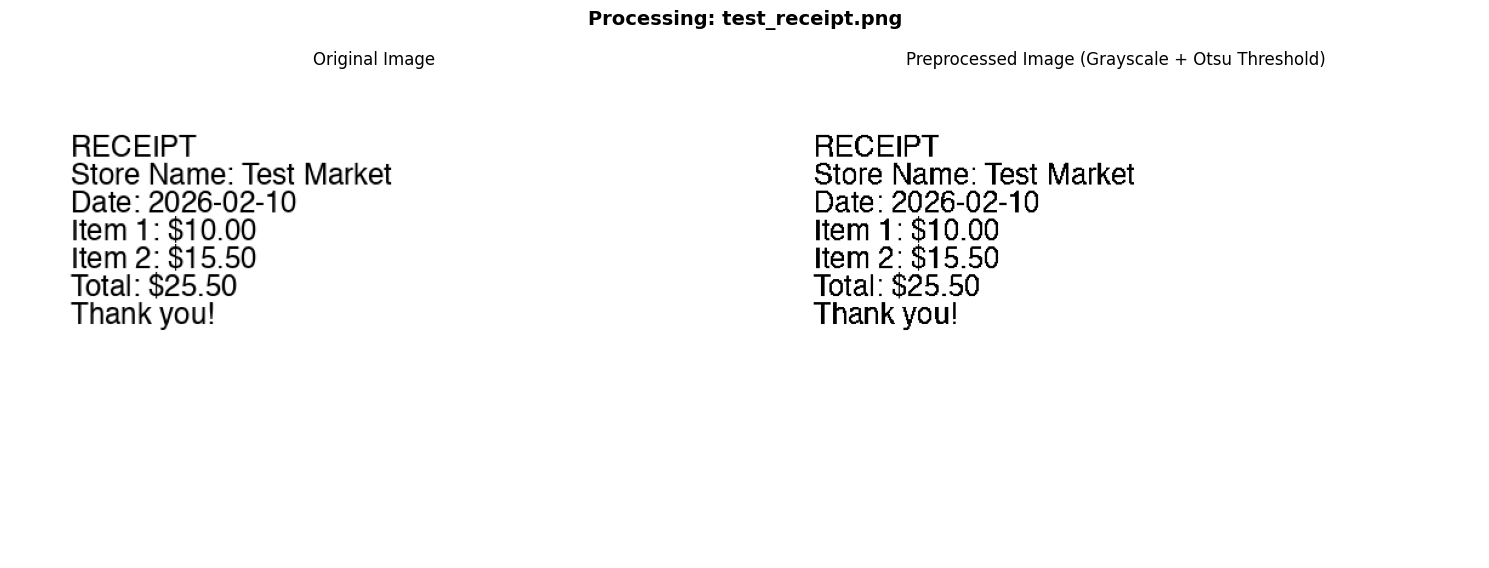

2026-02-11 20:57:55,173 - agent_api.services.ocr - INFO - Starting OCR text extraction with language: eng
2026-02-11 20:57:55,587 - agent_api.services.ocr - INFO - OCR completed. Extracted 108 characters with 49.97% confidence

📊 Results:
  • Confidence Score: 49.97%
  • Accuracy: 100.00%
  • Preprocessing Time: 3.25ms
  • OCR Time: 414.84ms
  • Total Time: 418.09ms
  • Characters Extracted: 108

📝 Extracted Text:
------------------------------------------------------------
RECEIPT

Store Name: Test Market
Date: 2026-02-10

Item 1: $10.00

Item 2: $15.50

Total: $25.50

Thank you!
------------------------------------------------------------

✓ Ground Truth:
------------------------------------------------------------
RECEIPT
Store Name: Test Market
Date: 2026-02-10
Item 1: $10.00
Item 2: $15.50
Total: $25.50
Thank you!
------------------------------------------------------------


In [17]:
def create_test_image(text: str, filename: str = "test_receipt.png") -> str:
    """Create a simple test image with text."""
    from PIL import Image, ImageDraw, ImageFont
    
    # Create white background
    img = Image.new('RGB', (600, 400), color='white')
    draw = ImageDraw.Draw(img)
    
    # Try to use a better font, fall back to default if not available
    try:
        font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 24)
    except:
        font = ImageFont.load_default()
    
    # Draw text
    draw.text((50, 50), text, fill='black', font=font)
    
    # Save
    output_path = f"/tmp/{filename}"
    img.save(output_path)
    print(f"✅ Test image created: {output_path}")
    
    return output_path

# Create and test a sample image
sample_text = """RECEIPT
Store Name: Test Market
Date: 2026-02-10
Item 1: $10.00
Item 2: $15.50
Total: $25.50
Thank you!"""

test_img_path = create_test_image(sample_text)

# Test the created image
sample_result = await test_single_image(
    image_path=test_img_path,
    ground_truth=sample_text,
    lang="eng",
    show_images=True
)

## 9. Export Results

Save test results to CSV for further analysis.

In [18]:
def export_results(results: List[Dict], filename: str = "ocr_test_results.csv"):
    """Export test results to CSV."""
    df = pd.DataFrame(results)
    output_path = f"/tmp/{filename}"
    df.to_csv(output_path, index=False)
    print(f"✅ Results exported to: {output_path}")
    return output_path

# Example usage (after running batch tests):
# export_results(batch_results)

print("✅ Export function ready!")

✅ Export function ready!
